In [27]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import itertools

In [28]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [29]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [30]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data.dropna(inplace=True)

    result = data
    # print(result.head(10))
    return result

In [31]:
def prepare_data(data, target_column, look_back=1):

    data = modify_data(data)

    scaler = StandardScaler()
    features = data.drop(columns=[target_column, 'Date'])
    targets = data[target_column]
    features_scaled = scaler.fit_transform(features)
    
    X, y = [], []
    for i in range(len(features_scaled) - look_back):
        X.append(features_scaled[i:(i + look_back)])
        y.append(targets.iloc[i + look_back])
    
    X, y = np.array(X), np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    return X_train, X_test, y_train, y_test

In [32]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [33]:
def build_model(input_shape, md_prm: dict):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])
    return model

In [34]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    early_stopping = EarlyStopping(
        monitor             ='val_rmse',
        patience            =10,
        verbose             =1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )
    return history

In [35]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [36]:
def plot_predictions(y_true, y_pred, n, title="Prediction vs Actual Data", markersize=4):
    # Asegurarse de que n no sea mayor que el número de puntos disponibles
    n = min(n, len(y_true), len(y_pred))

    # Usar slicing para obtener los últimos n valores
    y_true = y_true[-n:]
    y_pred = y_pred[-n:]

    plt.figure(figsize=(12, 2))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7) 

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [37]:
# n_steps: 5, rnn_units: 100, activation: tanh, dropout: 0.2, batch_size: 16, epochs: 100

# n_steps_options = [5, 10]
# batch_size_options = [16, 32, 64]
# epochs_options = [100]
# lstm_units_options = [50, 100]
# activation_options = ['relu']
# dropout_options = [0.1, 0.2]
# num_layers_options = [1, 2]

n_steps_options = [5, 10]
batch_size_options = [16, 32, 64]
epochs_options = [100]
lstm_units_options = [50]
activation_options = ['relu']
dropout_options = [0.1]
num_layers_options = [2]

# learning_rate_options = [0.001, 0.01, 0.1]
# optimizer_options = ['adam', 'sgd', 'rmsprop']

# Crear combinaciones de parámetros
model_params_combinations = list(itertools.product(
    n_steps_options, 
    lstm_units_options, 
    activation_options, 
    dropout_options,
    num_layers_options,  # Incluido para múltiples capas LSTM
    batch_size_options,
    epochs_options
))
target_column = 'LMCADY_acu_5d_log'

In [38]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 6


In [39]:
def run_model_iterations():
    top_results = []
    i = 1
    for params in model_params_combinations:
        n_steps, lstm_units, activation, dropout, num_layers, batch_size, epochs = params
        try:
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            print("Params: n_steps: {}, lstm_units: {}, activation: {}, dropout: {}, num_layers: {}".format(
                n_steps, lstm_units, activation, dropout, num_layers))

            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)

            model_params = {
                'lstm_units': lstm_units,
                'activation': activation,
                'dropout': dropout,
                'num_layers': num_layers
            }

            input_shape = (X_train.shape[1], X_train.shape[2])
            model = build_model(input_shape, model_params)
            print(model.summary())

            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            y_pred = model.predict(X_test)
            rmse_score = math.sqrt(mean_squared_error(y_test, y_pred))
            std_dev = np.std(y_test)

            diff = rmse_score - std_dev

            result = {
                'n_steps': n_steps,
                'lstm_units': lstm_units,
                'activation': activation,
                'dropout': dropout,
                'num_layers': num_layers,
                'batch_size': batch_size,
                'epochs': epochs,
                'rmse': rmse_score,
                'std_dev': std_dev,
                'diff': diff,
                'predictions': y_pred,
                'true_values': y_test
            }

            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['diff'])[:5]

            print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(rmse_score, std_dev, diff))
            print("Completed Iteration {}/{}".format(i, n_iterations))

        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i += 1

    return top_results

In [40]:
top_3_results = run_model_iterations()


Iteration 1/6
Params: n_steps: 5, lstm_units: 50, activation: relu, dropout: 0.1, num_layers: 2
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 5, 50)             12200     
                                                                 
 dropout_23 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_24 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_24 (Dropout)        (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 32451 (126.76 KB)
Trainable params: 32451 (126.76 KB)
Non-trainable params

In [41]:
top_3_results = sorted(top_3_results, key=lambda x: x['diff'])[:5]

Top 1 
RMSE: 0.031459, STD_DEV: 0.030935, DIFF: 0.000525
n_steps: 5, rnn_units: 50, activation: relu, dropout: 0.1, batch_size: 32, epochs: 100


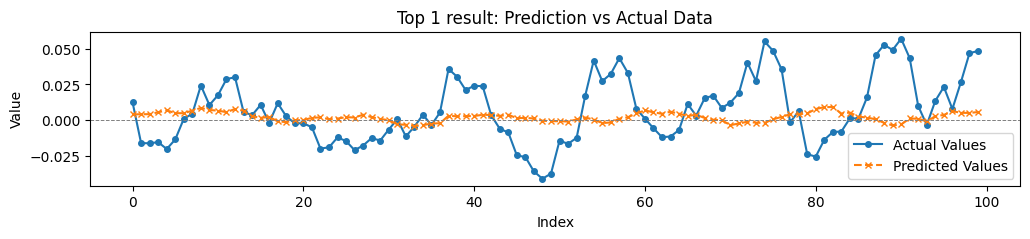

Top 2 
RMSE: 0.031741, STD_DEV: 0.030935, DIFF: 0.000807
n_steps: 5, rnn_units: 50, activation: relu, dropout: 0.1, batch_size: 64, epochs: 100


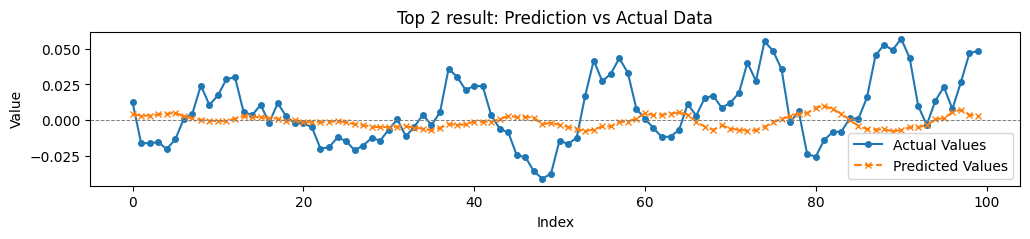

Top 3 
RMSE: 0.032431, STD_DEV: 0.030935, DIFF: 0.001497
n_steps: 5, rnn_units: 50, activation: relu, dropout: 0.1, batch_size: 16, epochs: 100


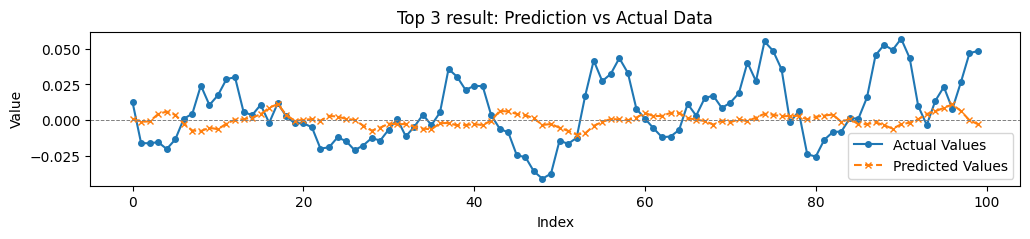

Top 4 
RMSE: 0.032621, STD_DEV: 0.030948, DIFF: 0.001674
n_steps: 10, rnn_units: 50, activation: relu, dropout: 0.1, batch_size: 32, epochs: 100


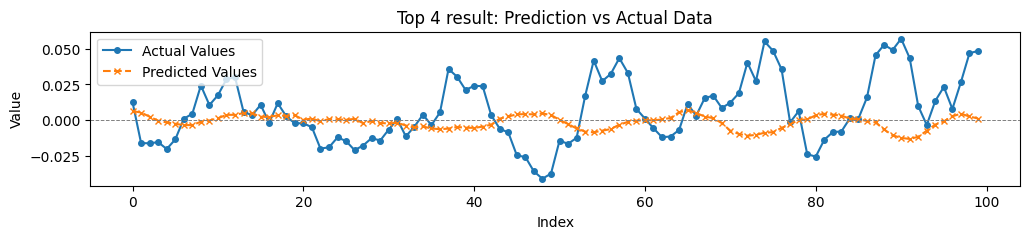

Top 5 
RMSE: 0.032818, STD_DEV: 0.030948, DIFF: 0.001871
n_steps: 10, rnn_units: 50, activation: relu, dropout: 0.1, batch_size: 64, epochs: 100


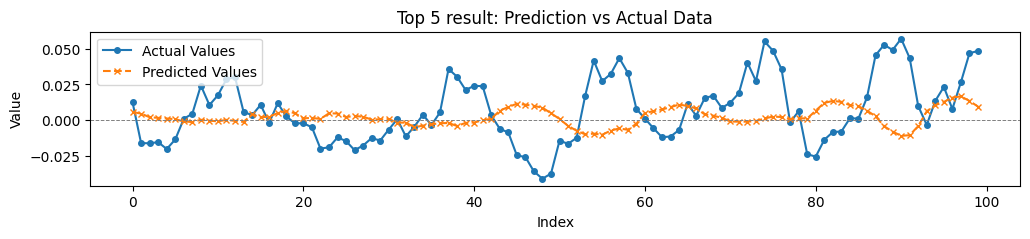

In [43]:
for i,result in enumerate(top_3_results,1):
    print(f"Top {i} ")
    print("RMSE: {:.6f}, STD_DEV: {:.6f}, DIFF: {:.6f}".format(result['rmse'], result['std_dev'], result['diff']))
    print("n_steps: {}, rnn_units: {}, activation: {}, dropout: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['lstm_units'], result['activation'], result['dropout'], result['batch_size'], result['epochs']))
    plot_predictions(result['true_values'], result['predictions'], 100, title=f"Top {i} result: Prediction vs Actual Data")

In [ ]:
# export the best result predictions and true values to a csv file
best_result = top_3_results[0]
best_result_df = pd.DataFrame({'True Values': best_result['true_values'], 'Predictions': best_result['predictions'].flatten()})
best_result_df.to_csv('./output/rnn_best_result.csv', index=False)